# Augmentation on images

In [1]:
!pip install mycolorpy --quiet
from google.colab import drive
drive.mount('/content/gdrive')
%cd gdrive/MyDrive/M_DV_V2022

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/MyDrive/M_DV_V2022


In [2]:
import matplotlib.pyplot as plt
import numpy as np
from cv2 import Sobel, Laplacian, watershed
import cv2 as cv
import seaborn as sns

import seaborn as sns

from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from mycolorpy import colorlist as mcp


from PIL import Image

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input

import tensorflow as tf
from tensorflow.keras import backend as K

from unet_detection.models.vanilla_unet import vanilla_unet

## Load data

In [3]:
X_train = np.load("data/spec_lib/X_data.npy") 
#X_70_train = np.load("data/spec_lib/X_70_data.npy")
y_train = np.load("data/spec_lib/y_data.npy")

X_val = np.load("data/spec_lib/X_data_val.npy")
#X_70_val = np.load("data/spec_lib/X_70_data_val.npy")
y_val = np.load("data/spec_lib/y_data_val.npy")

X_test = np.load("data/spec_lib/X_data_test.npy")
#X_70_test = np.load("data/spec_lib/X_70_data_test.npy")
y_test = np.load("data/spec_lib/y_data_test.npy")

In [4]:
def redesign_y(y):
  n,r1,c1,d = y.shape
  # Adds a new dimension of layer too have two class problem.
  yy = np.append(y, np.zeros((n, r1, c1,d)), axis=3)
  for i in range(int(y.max()-1)):  
    yy = np.append(yy, np.zeros((n, r1, c1,d)), axis=3)
  #yy[yy >= 0.001] = 1
  yy1 = yy.copy()
  yy1[:,:,:,0] = 0 # reset map
  for i in range(n):
    values = yy[i,:,:,0]
    for r in range(r1):
      for c in range(c1):
        value = yy[i,r,c,0]
        yy1[i,r,c,int(value)] = 1

  return yy1

In [5]:
y_train = redesign_y(y_train)
y_val = redesign_y(y_val)
y_test = redesign_y(y_test)

print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

(150, 128, 128, 6)
(20, 128, 128, 6)
(50, 128, 128, 6)


## Weighten the y data

In [6]:
sample_weigths = np.ones((y_train.shape[0], y_train.shape[1], y_train.shape[2],1))
unik = np.unique(y_train.argmax(axis=3), return_counts=True)
y = y_train.argmax(axis=3)

In [7]:
ticks = ["None"]
ticks.extend(['ceramic',
 'concrete',
 'eternit',
 'metal',
 'tar roofing paper'])

In [22]:
for c,u in zip(unik[0], unik[1]):
  #print(c)
  vekt = (1/(u/sum(unik[1])))**1
  print(f"{ticks[c]:18}: {vekt:.5g},\tsamples: {u:7}, andel: {(u/sum(unik[1]))*100:5.4g} %")
  sample_weigths[y[:,:,:] == c] = vekt

None              : 1.1196,	samples: 2195124, andel: 89.32 %
ceramic           : 292.85,	samples:    8392, andel: 0.3415 %
concrete          : 13.354,	samples:  184035, andel: 7.488 %
eternit           : 130.83,	samples:   18784, andel: 0.7643 %
metal             : 92.394,	samples:   26599, andel: 1.082 %
tar roofing paper : 99.635,	samples:   24666, andel: 1.004 %


## Augmentation on data

In [23]:
def aug_brightness_and_flip(img, label, seed=None):
    rand = np.random.random()*(1.5-.5) + .5
    img = tf.image.adjust_contrast(img, contrast_factor=rand)
    img = tf.image.adjust_brightness(img, delta=rand-1)
    img = tf.image.adjust_gamma(img, gamma=rand)

    if np.random.random() < .5:
      img = tf.image.flip_left_right(img)
      label =tf.image.flip_left_right(label)


    return img, label



In [24]:
# Create a generator.
rng = tf.random.Generator.from_seed(123, alg='philox')

In [25]:
def f(x, y, w):
  seed = rng.make_seeds(2)[0]
  image, label = aug_brightness_and_flip(x, y, seed)
  return image, label, w

In [26]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train, sample_weigths))
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))

InternalError: ignored

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

In [ ]:
train_ds = (
    train_dataset
    .shuffle(1000)
    .map(f, num_parallel_calls=AUTOTUNE)
    .batch(32)
    .prefetch(AUTOTUNE)
)

val_ds = (
    val_dataset
    .batch(32)
    .prefetch(AUTOTUNE)
)

In [ ]:
def augment_brightness(X,y, n=10):
    datagen = ImageDataGenerator(horizontal_flip=True)
    # Xshape = (n, x,y,c)
    brigthness = [0.6, 0.7, 0.8, 0.9, 1.1, 1.2, 1.3, 1.4, 1.5]
    list_of_indx = np.linspace(0, X.shape[0]-1, X.shape[0], dtype=int)

    indx = np.random.choice(list_of_indx, size=n, replace=False)
    brigt = np.random.choice(brigthness, size=n)
    print(indx, brigt)
    img = []
    img_y = []

    for i,b in zip(indx, brigt):
      temp_img = datagen.apply_transform(X[i], {"flip_horizontal":True})
      img.append(temp_img * b)
      img_y.append(datagen.apply_transform(y[i], {"flip_horizontal":True}))

    img = np.array(img)
    img_y = np.array(img_y)
    return img, img_y

## Set up loss function. Matthews cor

In [28]:
def multi_mcc_loss(y_true, y_pred, false_pos_penal=1):
    # Reshape image to flatten form
    y_true = K.reshape(y_true, [-1, y_true.shape[-1]])
    y_pred = K.reshape(y_pred, [-1, y_pred.shape[-1]])

    confusion_m = tf.matmul(K.transpose(y_true), y_pred)
    if false_pos_penal != 1.0:
      """
      This part is done for penalization of FalsePos symmetrically with FalseNeg,
      i.e. FalseNeg is favorized for the same factor. In such way MCC values are comparable.
      If you want to penalize FalseNeg, than just set false_pos_penal < 1.0 ;)
      """
      confusion_m = tf.linalg.band_part(confusion_m, 0, 0) + tf.linalg.band_part(confusion_m, 0, -1)*false_pos_penal + tf.linalg.band_part(confusion_m, -1, 0)/false_pos_penal
    
    N = K.sum(confusion_m)
    
    up = N*tf.linalg.trace(confusion_m) - K.sum(tf.matmul(confusion_m, confusion_m))
    down_left = K.sqrt(N**2 - K.sum(tf.matmul(confusion_m, K.transpose(confusion_m))))
    down_right = K.sqrt(N**2 - K.sum(tf.matmul(K.transpose(confusion_m), confusion_m)))
    
    mcc = up / (down_left * down_right + K.epsilon())
    mcc = tf.where(tf.math.is_nan(mcc), tf.zeros_like(mcc), mcc)
    
    return 1 - K.mean(mcc)

## Set up unet and train

In [29]:
u = vanilla_unet()

img1 = Input(shape=(128,128,399))

model = u.get_unet(img1, None, n_classes=6, last_activation='softmax')

model.compile(optimizer='adam',
              loss=multi_mcc_loss)

tf.random.set_seed(10)

In [ ]:
h = model.fit(train_ds ,
              validation_data=val_ds, 
              batch_size=32,
              epochs=150,
              verbose=1)
              #sample_weight=sample_weigths)

Epoch 1/150
5/5 [==============================] - 9s 971ms/step - loss: 1.4898 - val_loss: 0.9171
Epoch 2/150
5/5 [==============================] - 4s 808ms/step - loss: 1.3716 - val_loss: 0.9092
Epoch 3/150
5/5 [==============================] - 4s 787ms/step - loss: 1.3179 - val_loss: 0.9386
Epoch 4/150
5/5 [==============================] - 4s 804ms/step - loss: 1.2791 - val_loss: 0.8829
Epoch 5/150
5/5 [==============================] - 4s 804ms/step - loss: 1.2526 - val_loss: 0.8599
Epoch 6/150
5/5 [==============================] - 4s 814ms/step - loss: 1.2284 - val_loss: 0.8550
Epoch 7/150
5/5 [==============================] - 4s 793ms/step - loss: 1.2072 - val_loss: 0.8458
Epoch 8/150
5/5 [==============================] - 4s 813ms/step - loss: 1.1903 - val_loss: 0.8350
Epoch 9/150
5/5 [==============================] - 4s 812ms/step - loss: 1.1738 - val_loss: 0.8292
Epoch 10/150
5/5 [==============================] - 4s 806ms/step - loss: 1.1725 - val_loss: 0.8224
Epoch 11/

Text(0.5, 1.0, 'with aug')

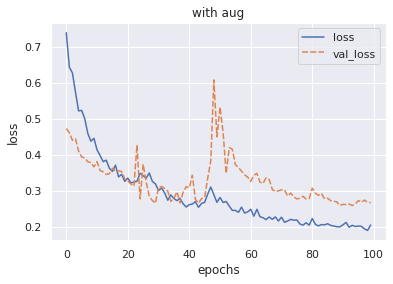

In [28]:
sns.set_theme()
sns.lineplot(data={key:(h.history[key][50:]) for key in ['loss', 'val_loss']})
plt.xlabel("epochs"); plt.ylabel("loss")
plt.title("with aug")

Text(0.5, 1.0, 'without aug and no weight')

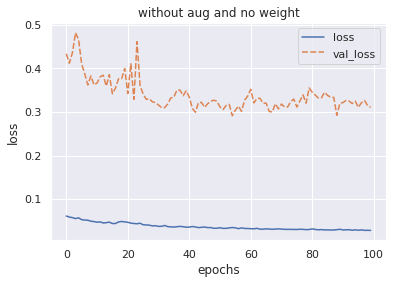

In [31]:
sns.set_theme()
sns.lineplot(data={key:(h.history[key][50:]) for key in ['loss', 'val_loss']})
plt.xlabel("epochs"); plt.ylabel("loss")
plt.title("without aug and no weight")

Text(0.5, 1.0, 'without aug and weight')

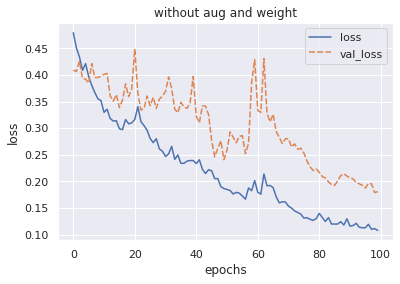

In [48]:
sns.set_theme()
sns.lineplot(data={key:(h.history[key][50:]) for key in ['loss', 'val_loss']})
plt.xlabel("epochs"); plt.ylabel("loss")
plt.title("without aug and weight")

## Validate data

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


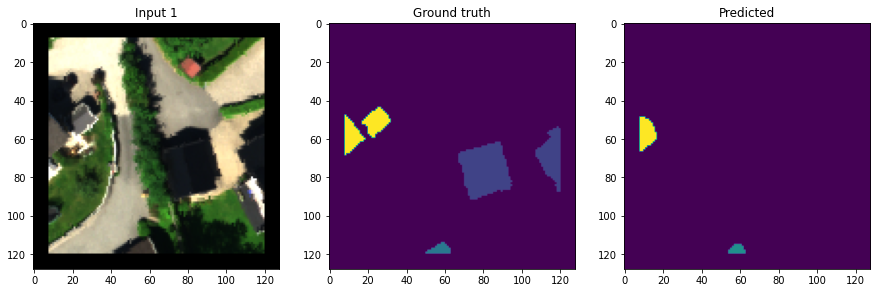

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


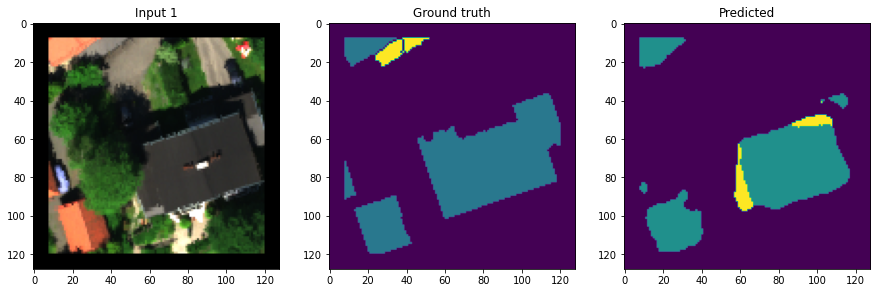

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


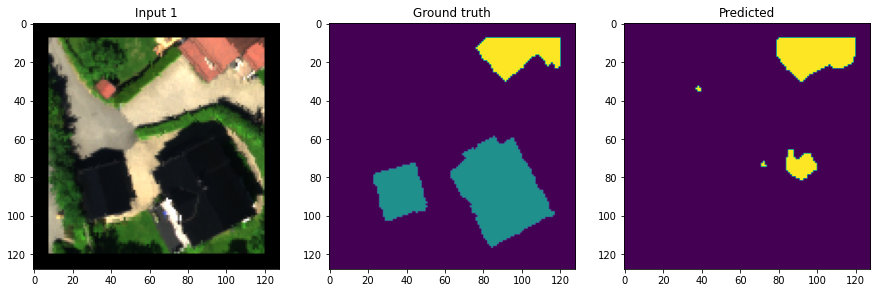

In [57]:
sns.reset_orig()
for _ in range(3):
  x = np.random.randint(X_val.shape[0])
  fig, (ax1,  ax3, ax4) = plt.subplots(nrows=1,ncols=3, figsize = (15,15))
  ax1.imshow(np.dstack((X_val[x:x+1][0][:,:,76],
                        X_val[x:x+1][0][:,:,46],
                        X_val[x:x+1][0][:,:,21]))/2500)
  
  #ax1.imshow(X_val[x:x+1][0][:,:,0:3])
  ax1.set_title("Input 1")

  #ax2.imshow(X_val[x:x+1][0][:,:,0:3])
  #ax2.imshow(np.dstack((X_70_val[x:x+1][0][:,:,137],
  #                      X_70_val[x:x+1][0][:,:,194],
  #                      X_70_val[x:x+1][0][:,:,207])))
  #ax2.set_title("Input 2")


  ax3.imshow(y_val[x:x+1].argmax(axis=3)[0])
  ax3.set_title("Ground truth")
  pred = model.predict([X_val[x:x+1]]).argmax(axis=3)[0]
  ax4.imshow(pred)
  ax4.set_title("Predicted")
  plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


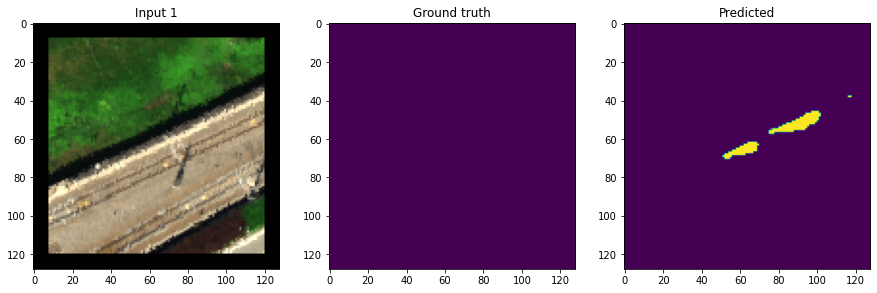

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


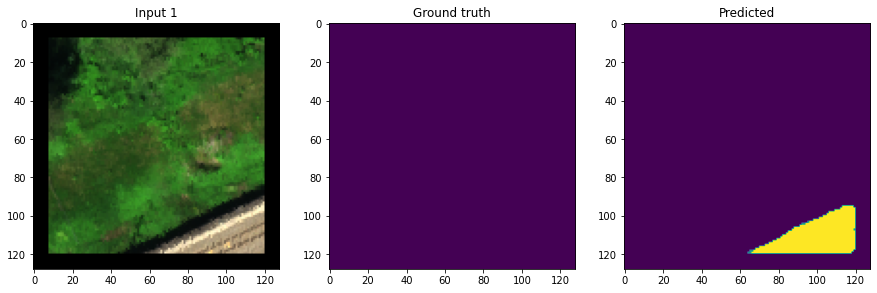

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


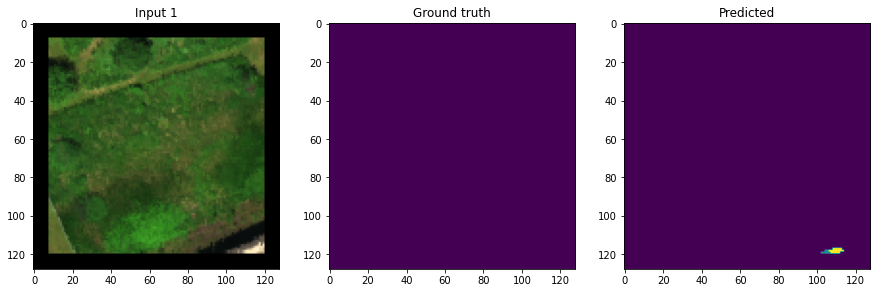

In [63]:
sns.reset_orig()
for _ in range(3):
  x = np.random.randint(X_test.shape[0])
  fig, (ax1,  ax3, ax4) = plt.subplots(nrows=1,ncols=3, figsize = (15,15))
  ax1.imshow(np.dstack((X_test[x:x+1][0][:,:,76],
                        X_test[x:x+1][0][:,:,46],
                        X_test[x:x+1][0][:,:,21]))/2500)
  
  #ax1.imshow(X_val[x:x+1][0][:,:,0:3])
  ax1.set_title("Input 1")

  #ax2.imshow(X_val[x:x+1][0][:,:,0:3])
  #ax2.imshow(np.dstack((X_70_val[x:x+1][0][:,:,137],
  #                      X_70_val[x:x+1][0][:,:,194],
  #                      X_70_val[x:x+1][0][:,:,207])))
  #ax2.set_title("Input 2")


  ax3.imshow(y_test[x:x+1].argmax(axis=3)[0])
  ax3.set_title("Ground truth")
  pred = model.predict([X_test[x:x+1]]).argmax(axis=3)[0]
  ax4.imshow(pred)
  ax4.set_title("Predicted")
  plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


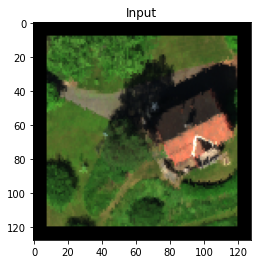

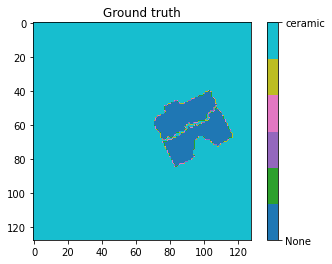

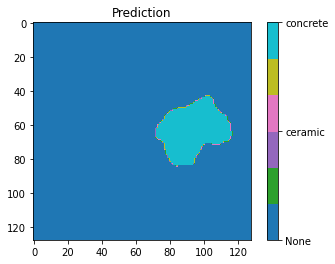

In [21]:
n = 23

plt.imshow(np.dstack([X_test[n,:,:,76], X_test[n,:,:,46], X_test[n,:,:,21]])/2500)
plt.title("Input")
plt.show()

ticks = ["None"]
ticks.extend(['ceramic',
 'concrete',
 'eternit',
 'metal',
 'tar roofing paper'])

colors=mcp.gen_color(cmap="tab10",n=6)
colormap = ListedColormap(colors)

plt.imshow(y_test[n:n+1,:,:,0][0], cmap=colormap)
#cbar = plt.colorbar()
cbar = plt.colorbar(ticks=[0,1,2,3,4,5])
cbar.ax.set_yticklabels(ticks)
plt.title("Ground truth")
plt.show()


pred = model.predict(X_test[n:n+1]).argmax(axis=3)[0]
plt.imshow(pred, cmap=colormap)
cbar = plt.colorbar(ticks=[0,1,2,3,4,5])
cbar.ax.set_yticklabels(ticks)
plt.title("Prediction")
plt.show()

In [ ]:

np.min(y_test[1])

0.0

In [ ]:
import seaborn as sns

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


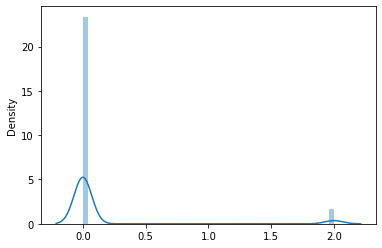

In [ ]:
sns.distplot(y_test[23].argmax(axis=2))

# MEtrcis

In [18]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
pred_tot = model.predict(X_test)

[Text(0, 0, 'None'),
 Text(0, 0, 'ceramic'),
 Text(0, 0, 'concrete'),
 Text(0, 0, 'eternit'),
 Text(0, 0, 'metal'),
 Text(0, 0, 'tar roofing paper')]

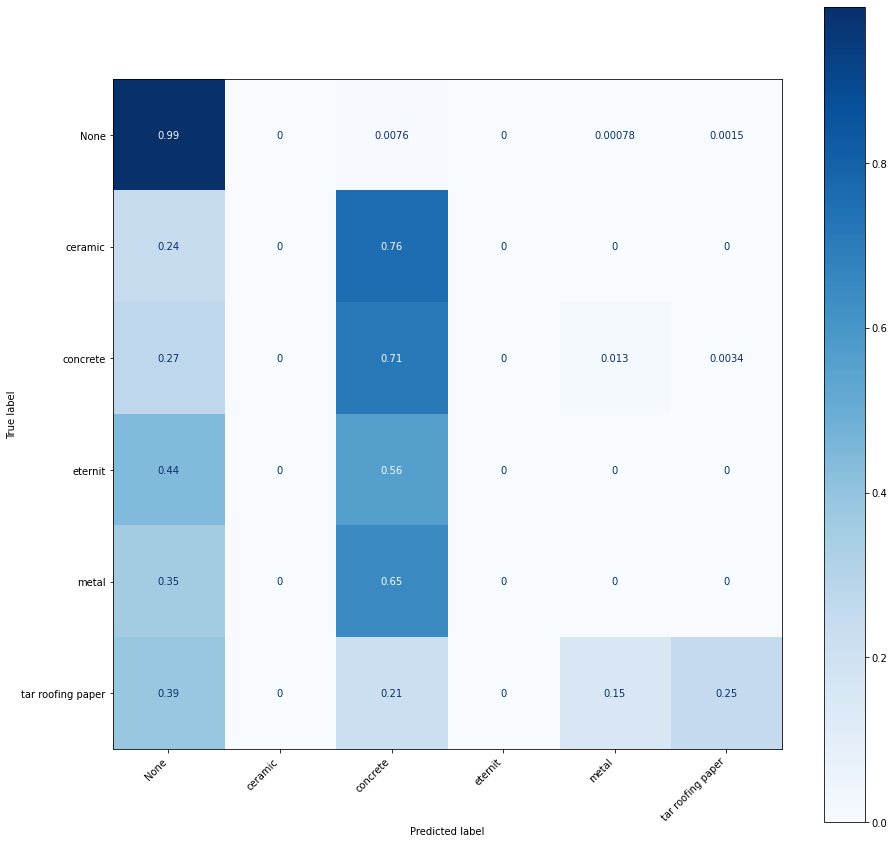

In [19]:
sns.reset_orig()
fig, ax = plt.subplots(figsize=(15, 15))

ticks = np.array(ticks)
true = ticks[y_test.argmax(axis=3).flatten()]
pre = ticks[pred_tot.argmax(axis=3).flatten()]

true_ = true[true != "None"]
pre_ = pre[pre != "Noen"]


disp = ConfusionMatrixDisplay.from_predictions(true, pre,
                                        labels=np.unique(ticks),
                                        cmap=plt.cm.Blues,
                                        xticks_rotation=45,
                                        ax=ax,
                                        normalize="true")
ax.set_xticklabels(ax.get_xticklabels() ,ha="right")

In [20]:
from sklearn.metrics import classification_report
print(classification_report(true,pre,target_names=ticks))

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                   precision    recall  f1-score   support

             None       0.98      0.99      0.99    776182
          ceramic       0.00      0.00      0.00      3662
         concrete       0.59      0.71      0.64     28048
          eternit       0.00      0.00      0.00      6260
            metal       0.00      0.00      0.00      1920
tar roofing paper       0.38      0.25      0.30      3128

         accuracy                           0.96    819200
        macro avg       0.33      0.33      0.32    819200
     weighted avg       0.95      0.96      0.96    819200



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
